In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as C

Variables que van a definir las condiciones de vuelo del cohete y las condiciones del propelente
Los indices

# Primer propelente

In [3]:
P0=1000 #psi
Pe=14.69 #psi=presion atmosferica
k=1.134514 #1.139544
M=38.19458 # kg/mol
To=1958.5557 #1940.74 #K
Wp=0.300 # peso del propelente en kg

# Hanab ku propelente

In [9]:
P0=1000 #psi
Pe=14.69 #psi=presion atmosferica
k=1.136231 #
M = 0.03686465 # kg/mol
To=1855.11 #1940.74 #K
theta= np.pi/2
r = 27.5/8 # g/s
rho_T = 1.8805 #densidad teorica
rho_e = 1.39 # g/cm^3 densidad medida
mp=0.350 # peso del propelente utilizado en la prueba

print(rho_e/rho_T)

0.7391651156607284


In [5]:

def match(Pe, P0, k):
    c=(k-1)/k
    return np.sqrt(2/(k-1)*(1-(Pe/P0)**c))

def RatArea(M1, M2, k):
    a=(k+1)/(2*(k-1))
    b=(k-1)/2
    return M2/M1*(((1+b*M1**2)/(1+b*M2**2))**a)

def Cf(Pe, P0, k):
    a=(k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k)))

def thrust(Cf,At,P0):
    return At*P0*Cf*6894.757*10**(-6)

def Isp(k, Pe, Po, To, M):
    R=C.R
    a=(k-1)/k
    Isp=(1/C.g)*np.sqrt(((2*To*(R/(M*a))))*(1-(Pe/Po)**a))
    return Isp

def diametro(A):
    return np.sqrt(4*A/C.pi)

def altura(m, mp, F, Isp, angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    
    # Fase 1
    t1=(Isp)*mp*C.g/F
    h1=1/2*ay*t1**2
    if h1>3000 :
        print("La fase 1 pasa de 3000 metros")
    
    V_y1=ay*t1
    
    # Fase 2
    t2=V_y1/C.g

    h=(ay*t1**2/2)*(1+ay/C.g)
    return h

def masa_propelente(F, Isp, m, h,angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    mp=(F/Isp)*np.sqrt(2*h/(C.g*ay)*(1/(C.g+ay)))
    return mp

def ex_vel(R, To, k):
    a = (k+1)/(k-1)
    c = np.sqrt(R*To/(k*(2/(k+1))**a))
    return c


In [6]:
m=50 # masa del cohete sin propelente
h=3000 # metros
theta=np.pi/2 #angulo

Mc=0.3
Mt=1
Me=match(Pe,P0,k)
Dc=101.6 #mm
Ac=C.pi*(Dc/2)**2 #mm**2
#Dc=diametro(Ac)  mm

## Tobera

In [7]:
AtAc=RatArea(Mt,Mc,k)
At=Ac*AtAc
AeAt=RatArea(Me,Mt,k)
Ae=At*AeAt
AeAc=RatArea(Me,Mc,k)
Ae2=Ac*AeAc
De2=diametro(Ae2)
De=diametro(Ae)
Dt=diametro(At)
Cf=Cf(Pe,P0,k)
F=thrust(Cf,At,P0)
Isp=Isp(k,Pe,P0,To,M) #159 s

In [8]:
Ab = np.pi*(Dc)
Kn = Ab/At
Po=Kn*rho*r*ex_vel(C.R/M, To , k)*1000 # g/cm^3*cm g/s m/s
print(Po)

NameError: name 'rho' is not defined

In [ ]:
print(De2/2,De/2,Dt/2,Dc/2,Mc,Me,Mt,Cf,F) # Dt,Dc=mm match,Cf=sin dimendiones, F=N

64.85604825796096 64.85604825796095 35.172979538992585 50.8 0.3 2.41455932750138 1 1.6365306719233723 43854.21134168535


Para poder obtener la masa total incluyendo el propelente se puede se puede resolver con una serie geometrica de la forma
$$
\frac{M}{m}=\Sigma_{n=0}^\infty (MR)^n=\frac{1}{1-MR} ,    |MR|<1
$$
Para poder obtener un MR razonable se necesita hacer un promedio de la funcion de mp/m=MR de la forma
$$
 MR=\langle \frac{mp}{m} \rangle=\frac{1}{I_{sp}}\sqrt{\frac{2hF}{gsen\theta}} \frac{1}{b-a}\int_a^b\frac{dm}{\sqrt{Fsen\theta-mg}} 
$$


In [ ]:
# Integral de mp/m
from scipy import integrate
h=3000
a, b = 40, 60
c=(1/Isp)*np.sqrt(2*h*F/(np.sin(theta)*C.g))
K= lambda m: c*(1/np.sqrt(F*np.sin(theta)-C.g*m))   

MR=1/(b-a)*(integrate.quadrature(K, a, b)[0]) # relacion de masa del propelente y el cohete

i = 0
m_p = [0]
M_tot = [m]
error=1
while error > 10**-6:
    
    m_p.append(M_tot[i]*K(M_tot[i]))
    M_tot.append(m+m_p[i+1])
    error= M_tot[i+1]-M_tot[i]
    #print(error, M_tot[-1])
    i+=1

Mtot=m*(1/(1-MR)) # masa total
h1=altura(Mtot ,Mtot-m, F, Isp, np.pi/2) #altura alcanzada
h2 = altura(M_tot[-1] ,m_p[-1], F, Isp, np.pi/2) # Altura con metodo iterativo
t=Isp*(Mtot-m)*C.g/F # tiempo de empuje

V=m_p[-1]*1000/rho # cm^3
L=V*1000/Ac # mm
# print(MR, K(50), Mtot, h1)
print(t, F, M_tot[-1], m_p[-1], h2, V, L, Isp) # mm

0.3258707571658895 43854.21134168535 58.59376142186129 8.59376142186129 2999.999974862006 6182.562174000927 762.5901566783607 169.76470007795893


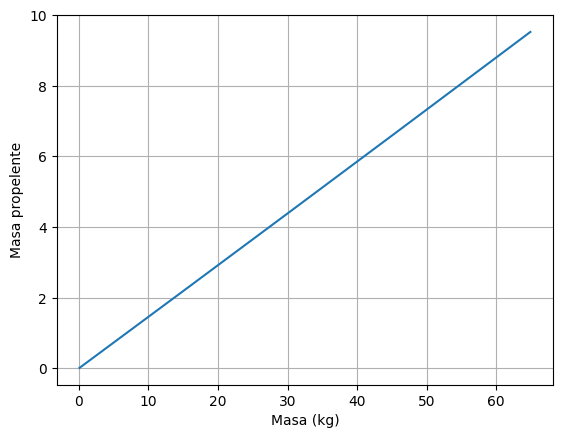

In [ ]:
x=np.arange(.1, 65 , 0.1)
y=masa_propelente(F, Isp, x, 3000, np.pi/2)

plt.plot(x,y)
plt.xlabel('Masa (kg)')
plt.ylabel('Masa propelente')
plt.grid()
plt.show()

In [ ]:
print(AeAc,Ac,AeAt,At, Ae) # En mm2

1.6299472207045387 8107.319665559963 3.400029205160078 3886.5851905588415 13214.503156242707


## Altitud